- **Author:** [Dace Apšvalka](https://www.mrc-cbu.cam.ac.uk/people/dace.apsvalka/) 
- **Date:** August 2024  
- **conda environment**: I used the [fMRI workshop's conda environment](https://github.com/MRC-CBU/COGNESTIC/blob/main/mri_environment.yml) to run this notebook and any accompanied scripts.

# fMRI Data Analysis: Subject-Level Analysis

Once the data have been pre-processed, we can proceed to the analysis. In this tutorial, we will focus on subject-level (or first-level) fMRI data analysis using [Nilearn](https://nilearn.github.io/stable/index.html). This process involves constructing a design matrix, fitting the model to the data, and computing beta maps (i.e., the estimated response for each condition) or contrast maps. Subject-level analysis is a crucial step before progressing to group-level analysis.

For analysing fMRI data, we commonly use general linear model (GLM). A GLM in fMRI analysis has the **BOLD signal** as the **outcome** variable (derived from the pre-processed functional MRI images) and **predictor** variables such as **events** (e.g., task conditions) and **confounds** (e.g., motion parameters). Typically analysis is performed by constructing a separate model for each voxel - **a mass univariate approach**. 

For more information on GLM, please see [Rik's Stats tutorial](../02_Statistics/cognestic_stats_python.ipynb) (corresponding [web link](https://github.com/MRC-CBU/COGNESTIC/tree/main/02_Statistics)).

And here are some recommended short videos to help better understand the principles of fMRI analysis:

In [1]:
from IPython.display import display, HTML

display(HTML('''
<div style="width: 1200px; margin: 0; display: flex; justify-content: space-around;">
    <div style="text-align: center;">
        <h3>GLM applied to fMRI (11 min)</h3>
        <iframe width="560" height="315" src="https://www.youtube.com/embed/OyLKMb9FNhg" frameborder="0" allow="picture-in-picture" allowfullscreen></iframe>
    </div>
    <div style="text-align: center;">
        <h3>Conditions and contrasts (12 min)</h3>
        <iframe width="560" height="315" src="https://www.youtube.com/embed/7MibM1ATai4" frameborder="0" allow="picture-in-picture" allowfullscreen></iframe>
    </div>
</div>

<div style="width: 1200px; margin: 0; display: flex; justify-content: space-around;">
    <div style="text-align: center;">
        <h3>Nuisance variables (14 min)</h3>
        <iframe width="560" height="315" src="https://www.youtube.com/embed/DEtwsFdFwYc" frameborder="0" allow="picture-in-picture" allowfullscreen></iframe>
    </div>
    <div style="text-align: center;">
        <h3>Multiple Comparisons (9 min)</h3>
        <iframe width="560" height="315" src="https://www.youtube.com/embed/AalIM9-5-Pk" frameborder="0" allow="picture-in-picture" allowfullscreen></iframe>
    </div>
</div>
'''))


----------------
**Table of contents**    
1. Import required packages   
2. Retrieve the preprocessed (fMRIprep) data   
3. Setting up GLM model components   
3.1. Dependent variable (Y): BOLD signal from each voxel of the functional MRI images    
3.2. Predictors (X): Events    
3.3. Predictors: Confounds    
4. Performing the GLM analysis    
4.1. Creating the First Level Model  
4.2. Fitting the model   
4.3. Inspecting the Design Matrix    
5. Contrast specification    
5.1. A simple case contrast    
5.2. Contrast scaling    
5.3. The final contrasts for our model    
6. Computing contrasts and plotting result maps    
6.1. Control the False Positive Rate    
6.2. False Discovery Rate (FDR) correction    
6.3. Family Wise Error (FWE) correction    
6.4. Cluster threshold    
7. The impact of first-level model parameters    
7.1. Model 1: Glover's HRF    
7.2. Model 2: SPM's HRF    
7.3. Plotting both models    
8. First Level for multiple subjects    
8.1. A generic first-level analysis script    
8.2. Processing multiple subjects in paralel   

-----------
## Import required packages

In [ ]:
# The conda environment used for this tutorial is available here: https://github.com/MRC-CBU/COGNESTIC/blob/main/mri_environment.yml 

import pandas as pd # for data manipulation
import numpy as np # for numerical operations

import matplotlib.pyplot as plt # for basic plotting

from bids.layout import BIDSLayout # to fetch data from BIDS-compliant datasets

# Nilearn modules, for the analysis of brain volumes, plotting, etc., https://nilearn.github.io/
from nilearn.glm.first_level import FirstLevelModel, compute_regressor, glover_hrf, spm_hrf
from nilearn.glm.thresholding import threshold_stats_img
from nilearn.plotting import plot_design_matrix, plot_contrast_matrix, plot_stat_map, plot_roi
from nilearn.maskers import NiftiSpheresMasker

## Retrieve the preprocessed (fMRIprep) data

BIDS applications, such as `fMRIprep`, output data into a data structure similar to `BIDS` organization principals. And these data also can be inspected using [PyBIDS](https://bids-standard.github.io/pybids/index.html).


In [ ]:
# --- Set up the paths to the BIDS data directory which includes derivatives
fmri_data_dir = 'FaceProcessing/data' # BIDS format data directory

# --- Set up the BIDS layoutt and include the derivatives in it
layout = BIDSLayout(fmri_data_dir, derivatives = True)

# or to include only a specific derivatives folder
# layout = BIDSLayout(fmri_data_dir, derivatives = 'path/to/derivatives')


## Setting up GLM model components

Remember (or refer to [Rik's stats](../02_Statistics/cognestic_stats_python.ipynb)) that GLM typically expressed as **Y = XB + e**, where **Y** is a vector containing the data, **X** is the 'design matrix' that defines the model for the data, **B** (or 'Betas') is a vector of parameters to be estimated, and **e** represents random error.

In the next sections, we will set up our GLM model by specifying the following:
* **The data (Y)**, which are our pre-processed functional images. These contain the time series data (length n; 210 in our case) for each voxel.
* **The design matrix (X)**, where we specify the effects (predictors) that may have influenced the acquired signal in the data. At a minimum, these effects include our experimental conditions, which we specify through event files containing the names and onsets of the conditions. Additionally, we can include other predictors, such as confounding (nuisance) variables, which are known to have occurred and likely influenced the data. Including these can help explain the acquired signal. We get a large list of confounding variables from the fMRIPrep output (confound files). The size of the design matrix must be n x p (time series length x number of predictors). There should be more data points (n) than predictors (p), so be cautious not to include too many confounding variables.

Nilearn will use the specified inputs for the GLM analysis and compute the beta estimates for each predictor. We can then define contrasts to compare beta estimates between conditions—for example, to test whether seeing Faces had a greater effect on the signal than seeing Scrambled images.

Let's set up our GLM model.

### Dependent variable (Y): BOLD signal from each voxel of the functional MRI images

We need to specify which MRI images we want to analyse. Here, we will focus on a single subject's **9 functional runs**. Using PyBIDS, we can easily locate the preprocessed files required for the analysis. Let's retrieve the preprocessed functional image files for **subject sub-04**.

In [ ]:
sID = '04'

preproc_functional_files = layout.get(
    subject = sID, 
    datatype = 'func', 
    desc = 'preproc', 
    extension = '.nii.gz',
    return_type = 'filename'
)

print('\nSubject''s', sID, 'preprocessed functional images:')
print(*preproc_functional_files, sep='\n')

We will also specify the subject's anatomical image (warped to the standard space) to use it as a background image when plotting results. 

In [ ]:
preprocessed_anatomical_file = layout.get(
    subject = sID, 
    datatype = 'anat', 
    space = 'MNI152NLin2009cAsym', 
    desc = 'preproc', 
    extension = '.nii.gz',
    return_type ='filename'
)[0]

print('Subject''s', sID, 'preprocessed anatomical image:')
print(preprocessed_anatomical_file)

The functional images contain time series data for each voxel. The GLM will be fitted, and beta estimates will be computed for each voxel.

Let's extract the time series of one voxel from the first run to get a sense of how our dependent variable looks.

In [ ]:
# voxel of interest
MNI_coord = [(41,	-48,	-18)] 

# extract the time series 
coord_masker = NiftiSpheresMasker(
    MNI_coord, t_r=2, standardize='zscore'
)
coord_time_series = coord_masker.fit_transform(
  preproc_functional_files[0]
  )

# plot the time series  
plt.figure(figsize=(18, 6))

plt.plot(coord_time_series, color='grey')

plt.title(f"run-01 {MNI_coord[0]} voxel time series")
plt.xlabel('Time (TRs)')
plt.ylabel('BOLD signal (z-scored)')
plt.show()


The BOLD signal in this voxel during the 7-minute functional run comes from various sources. We want to determine whether our experimental conditions (viewing Famous, Unfamiliar, or Scrambled faces) contribute to this signal, and if so, by how much. To better estimate this, we aim to regress out other potential contributors that we are not interested in, such as head movement artifacts, scanner drift, and other noise.

### Predictors (X): Events

Next, we need to specify the events that occurred during the functional acquisitions. The event files are stored in the `data/func` folder, and again, we can use `PyBIDS` to locate them.

In [ ]:
event_files = layout.get(
    subject = sID, 
    datatype = 'func', 
    suffix = 'events', 
    extension = ".tsv", 
    return_type = 'filename'
)
print('Subject''s', sID, 'event files:')
print(*event_files, sep='\n')

Event files contain the names of our experimental conditions, their onset times (in seconds), and their durations (in seconds). The events table will have as many rows as there are trials you want to include in the model.

In [ ]:
# load and display one of the event files
events_run1 = pd.read_csv(event_files[0], sep='\t')
events_run1

In the GLM's design matrix, we include one regressor (the same length as the time series data points) for each condition. The regressor represents the predicted BOLD response to the stimulus. The BOLD signal does not simply switch from 0 to 1 (on or off); instead, it follows a specific shape known as the **haemodynamic response function (HRF)**. The HRF models the delayed and dispersed nature of the BOLD signal in response to neural activity, typically peaking a few seconds after the stimulus and then gradually returning to baseline.

To obtain our condition's predicted BOLD response, we convolve the onset and duration times of the condition with an HRF. Several HRF models have been derived from research, with two of the most commonly used in typical populations being Glover's HRF and SPM's HRF.

To see how it works, let's create a regressor for the **FAMOUS_1** condition. We'll use the condition's onset and duration times from the event file and convolve them with Glover's HRF. Nilearn has a built-in function for this ([glm.first_level.compute_regressor](https://nilearn.github.io/stable/modules/generated/nilearn.glm.first_level.compute_regressor.html)), so we will use that.

In [ ]:
# Filter events_run1 DataFrame for the 'FAMOUS_1' condition
famous1_events = events_run1[events_run1['trial_type'] == 'FAMOUS_1']

# Extract onsets and durations for the 'FAMOUS_1' condition
onsets_famous1 = famous1_events['onset'].values
durations_famous1 = famous1_events['duration'].values
# Set amplitudes to 1 for all events
amplitudes_famous1 = np.ones_like(onsets_famous1)  

# Create a list of frame times (number of data points x TR, sampled every TR)
TR = 2
frame_times = np.arange(0, 210*TR, TR) 

# Create the regressor for 'FAMOUS_1' condition
regressor_famous1, _ = compute_regressor(
  [onsets_famous1, durations_famous1, amplitudes_famous1],
  hrf_model='glover', 
  frame_times=frame_times
)

# plot the regressor and also show the onsets
plt.figure(figsize=(18, 6))

plt.plot(frame_times, regressor_famous1)
plt.plot(onsets_famous1, np.zeros_like(onsets_famous1), 'o')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude (a.u.)')
plt.legend(['Predicted BOLD response', 'Stimulus onset'])
plt.title('Predicted BOLD response for the FAMOUS_1 condition')

In Nilearn, we don’t need to manually create these regressors when setting up the first-level model; we only need to provide the event files and ensure they contain the '*onset*', '*duration*', and '*trial_type*' columns.

### Predictors: Confounds

Confounds represent fluctuations with a potential non-neuronal origin, such as head motion artifacts, scanner noise, and cardiac or respiratory effects. We can include them in the GLM as regressors of no interest to minimize the confounding effects of non-neuronal signals. fMRIPrep calculates a wide range of possible confounds. You can find detailed information in the [fMRIPrep documentation](https://fmriprep.org/en/stable/outputs.html#confounds).

Which confounding variables you include in the GLM depends on the analysis you want to perform. The most well-established confounds are the six head-motion parameters (three rotations and three translations). If your dataset includes physiological recordings (e.g., heart rate, respiration), you might consider including these as confounds. If not, you might include PCA components from CompCor, a method implemented in fMRIPrep that identifies noise components from CSF and white matter signals. **However, please read the fMRIPrep documentation on confounds carefully before including any additional confounds, and never include all confounds in the GLM design matrix!**

If your study has specific considerations (e.g., participant behavior or task-related noise), you may need to include additional custom confounds.

The confounds computed by `fMRIPrep` can be found in the `data/derivatives/fmriprep/{sub}/func/` directory. They are stored separately for each run in `.tsv` files, with one column for each confound variable. Let's use `PyBIDS` to locate these files.

In [ ]:
confound_files = layout.get(
    subject = sID, 
    datatype = 'func', 
    desc = 'confounds', 
    extension = ".tsv", 
    return_type = 'filename'
)

print('Subject''s', sID, 'confound files:')
print(*confound_files, sep='\n')

Let's get a list of all confounds of the first functional run. 

In [ ]:
confounds_run1 = pd.read_table(confound_files[0])

print('Number of confounds in run 1:', len(list(confounds_run1)))
print('Number of data points for ech confound:', len(confounds_run1), '\n')
#print(*list(confounds_run1), sep='\n')
confounds_run1


In this example, we will include only the most commonly used confounds—the **six motion parameters**.

Additionally, we need to include **a regressor for each dummy scan** (we had two in this case).

**! Important**: If your data contains dummy scans and you specified this when running fMRIPrep, dummy scan confounds (non_steady_state_outlier##) will also be generated, and you must include them in your GLM! This ensures that the dummy volumes do not contribute to the parameter estimates.

Since we had two dummy scans, we will include the two '*non_steady_state_outliers*' in our design.

In [13]:
confounds_of_interest = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 
                         'non_steady_state_outlier00', 'non_steady_state_outlier01']


Let's display the confounds of interest of the first run.

In [ ]:
confounds_run1[confounds_of_interest]

Out of interest, we can use the `fit_transform` function again, which we previously used to extract an example voxel's time series, but this time, we'll include the confounds to regress them out from the data.

In [15]:
## This we used to extact the original time series:
# coord_masker = NiftiSpheresMasker(
#     MNI_coord, t_r=2, standardize='zscore'
# )

# coord_time_series = coord_masker.fit_transform(
#   preproc_functional_files[0]
#   )

# Now we will extract the time series with the confounds of interest regressed out
coord_time_series_no_confounds = coord_masker.fit_transform(
  preproc_functional_files[0], 
  confounds = confounds_run1[confounds_of_interest]
  )


In [ ]:
# plot the time series with and without confounds
plt.figure(figsize=(18, 6))

plt.plot(coord_time_series, label='original time series', color='blue', linewidth=2)
plt.plot(coord_time_series_no_confounds, label='time series without confounds', color='orange', linestyle='--', linewidth=2, alpha=0.8)

plt.title(f"run-01 {MNI_coord[0]} voxel time series with and without confounds")
plt.xlabel('Time (TRs)')
plt.ylabel('BOLD signal (z-scored)')
plt.legend()
plt.show()

We need to select the confounds of interest from the other eight runs as well. We will include the confounds of interest from each run in our GLM model by creating a list of confound tables.

In [17]:
confounds_for_glm = []
for conf_file in confound_files:
    this_conf = pd.read_table(conf_file)
    conf_subset = this_conf[confounds_of_interest].fillna(0) # replace NaN with 0
    confounds_for_glm.append(conf_subset)

## Performing the GLM analysis

Now we have the BOLD images, event files, and confounds for each of the 9 functional runs. Nilearn will analyse them together and **compute fixed-effects statistics for this subject**.

Next, we will create and estimate a `FirstLevelModel` object, which **will generate our design matrix based on the inputs we have provided**.

### Creating the First Level Model

Now we can specify the model with the parameters of our choice (see the [documentation](https://nilearn.github.io/stable/modules/generated/nilearn.glm.first_level.FirstLevelModel.html) for a full list of parameters). Here we will specify the folowing:
* **t_r** - repetition time (the sampling interval of the functional runs) in seconds. We can get it from our BIDS layout.

In [ ]:
# Get the TR
TR = layout.get_tr()
print('TR:', TR)

* **slice_time_ref**: *This parameter indicates the time of the reference slice used in the slice timing preprocessing step of the experimental runs. It is expressed as a percentage of the t_r (time repetition), so it can have values between 0. and 1. Default=0.* 
  
  We can find this information in our fMRIPrep Methods (*data/derivatives/fmriprep/logs/CITATION.html*). There we read: *"BOLD runs were slice-time corrected to 0.974s (0.5 of slice acquisition range 0s-1.95s)"*. This means, that **0.5** is the value we need to use for this parameter. 
  
  Alternativel, and perhaps preferably, we can obtain this information from the BIDS derivatives metadata. It also tells if the slice-time correction was performed at all. 

  `*data\derivatives\fmriprep\sub-{sID}\func\sub-{sID}_task-facerecognition_run-{runID}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.json*`
  ```json
    {
      "RepetitionTime": 2,
      "SkullStripped": false,
      "SliceTimingCorrected": true,
      "StartTime": 0.974,
      "TaskName": "faceprocessing"
    }
```

The metadata indicates that slice-time correction was applied, and the start time was adjusted from 0 to 0.974—representing the middle of the acquisition range.

In [ ]:
# If slice timing correction was applied, get the slice time reference
slice_timing = layout.get_metadata(preproc_functional_files[0])
if slice_timing['SliceTimingCorrected']:
  slice_time_ref = slice_timing['StartTime'] / TR
  print('Slice timing reference:', slice_time_ref)
else:
  slice_time_ref = 0
  print('Slice timing correction was not applied')

* **hrf_model**: defines the HRF model to be used. Possible options:
  * `spm`: This is the HRF model used in SPM. 
  * `spm + derivative`: SPM model plus its time derivative. This gives 2 regressors.
  * `spm + derivative + dispersion`: Idem, plus dispersion derivative. This gives 3 regressors.
  * `glover`: This corresponds to the Glover HRF.
  * `glover + derivative`: The Glover HRF + time derivative. This gives 2 regressors. 
  * `glover + derivative + dispersion`: Idem, plus dispersion derivative. This gives 3 regressors. 
  * `fir`: Finite impulse response basis. This is a set of delayed dirac models.

It can also be a custom model. In this case, a function should be provided for each regressor.
  
The choice of the HRF model is up to the user. There's little difference between using the SPM or Glover model. It's advisable to include derivatives when there's some uncertainty in the timing information, as this can help identify timing problems more effectively.

Let's see how, for example, SPM and Glover HRFs compare.

In [ ]:
# modeled time in seconds
time_length = 32

# Generate the HRF timecourses
glover_timecourse = glover_hrf(TR, time_length=time_length)
spm_timecourse = spm_hrf(TR, time_length=time_length)

# Plot the timecourses
timepoints = np.linspace(0, time_length, num=len(glover_timecourse))
plt.plot(timepoints, glover_timecourse, label='Glover HRF', color='blue')
plt.plot(timepoints, spm_timecourse, label='SPM HRF', color='red')
plt.title('Comparison of Glover and SPM HRF Timecourses')
plt.xlabel('Time (seconds)')
plt.ylabel('HRF Amplitude (a.u.)')
plt.legend()
plt.grid(True)
plt.show()

* **drift_model**: Specifies the desired drift model for the design matrices. It can be '*polynomial*', '*cosine*', or *None*. The default is '*cosine*'. Additional nuisance regressors are added to the design matrix to account for low-frequency noise (such as scanner drift or physiological fluctuations) that are unlikely to come from the experimental conditions. 
* **high_pass**: Used only if drift_model is *'cosine'*. Default is 0.01 Hz (1/128 Hz). It defines the cutoff frequency for the cosine drift model, and cosine functions with frequencies lower than this threshold are added as drift regressors. This ensures that only higher-frequency components, typically associated with neural activity, remain unmodeled in the design matrix.
* **smoothing_fwhm**: the full-width at half maximum in millimeters of the spatial smoothing to apply to the signal (smoothing was not done in fMRIPrep!).
* **noise_model**: {‘ar1’, ‘ols’} The temporal variance model. Default=’ar1’.

In [21]:
first_level_model = FirstLevelModel(
    t_r = TR,
    slice_time_ref = slice_time_ref,
    smoothing_fwhm = 6, # a rule of thumb is 3x the voxel size
    hrf_model = 'glover', # default
    drift_model = 'cosine', # default
    high_pass = 0.01, # default; Used only if drift_model is ‘cosine’ to set its cutoff frequency
    noise_model = 'ar1', # default
    memory = 'FaceProcessing/scratch', # kernel kept dying without this; Path to the directory used to cache the masking process and the glm fit.
    n_jobs = 2 # use two CPUs for computation
   # mask_img = path_to_mask_image, # default is None and Nilearn will compute it
)

### Fitting the model

Now that we have specified the model, we can run it on our data. We need to include the list of our functional image files, the list of event timing files, and the list of our confound tables (one per run).

In [ ]:
first_level_model = first_level_model.fit(preproc_functional_files, event_files, confounds_for_glm)

# If the kernel keeps dying here, then fit only the first two runs
#first_level_model = first_level_model.fit(preproc_functional_files[:2], event_files[:2], confounds_for_glm[:2])

# Remove the cashed directory
!rm -rf FaceProcessing/scratch/joblib/

In [23]:
# Remove the cashed directory
!rm -rf FaceProcessing/scratch/joblib/

### Inspecting the Design Matrix

We can now inspect the design matrix of our GLM model (rows represent time, and columns contain the predictors).

The `design_matrices` is a list of 9 tables (one per run). Let's look at the first run's design matrix.

In [ ]:
# get the design matrices from the glm model
design_matrices = first_level_model.design_matrices_

print('Design matrix for run', 1)
plot_design_matrix(design_matrices[0], output_file=None)

fig = plt.gcf()
fig.set_size_inches(8,2)
plt.show()

It seems that one of the non-steady-state volumes 'spoils the image'. It's a good thing we are excluding them from our analysis.

However, for visualisation purposes, let's exclude the two dummy regressors from our design matrix plot.

In [ ]:
# exclude the first two rows of the design matrix
plot_design_matrix(design_matrices[0].iloc[2:], output_file=None)

fig = plt.gcf()
fig.set_size_inches(8,2)
plt.show()

Let’s also take a look at the data included in the design matrix.

In [ ]:
# display the design matrix of the first run
design_matrices[0]

You may notice that the values for FAMOUS_1 are somewhat different from the values in the event regressor `regressor_famous1` that we calculated earlier. This is because the onset time of the events is not 0, but 0.974, as you may have also noticed. **Why is that?**

In the design matrix, we can observe several drift regressors. These are generated from the `drift_model` ('*cosine*') that we specified for our GLM model, capturing frequencies lower than the threshold set by the `high_pass` parameter. These regressors account for slow oscillations, which are unlikely to arise from our experimental conditions.

Now, let's plot the event regressors alongside the low-frequency drift regressors to better visualise these concepts.

In [ ]:
dm = design_matrices[0]
event_regressors = dm.columns[:9]
drift_regressors = [col for col in dm.columns if col.startswith('drift_')]

plt.figure(figsize=(18, 6))

# Plot the predicted event responses
for event in event_regressors:
    plt.plot(dm.index, dm[event], lw=1)

# Plot the modeled noise
for drift in drift_regressors:
    plt.plot(dm.index, dm[drift], color='grey', lw=1, linestyle='--')
    
plt.title('run-01 predicted event responses and modeled noise')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (a.u.)')

plt.show()


We can see how the low-frequency drifts differ in shape and timing from the event-related signals. This helps illustrate how the GLM separates task-related neural activity from unrelated noise.

Ideally, the event regressors should not overlap much with the drift regressors. It's not a problem in our event-relighted design, but could be more problematic in slow block-designs. Significant overlap could suggest that some task-related variance is being captured by the noise model, reducing the sensitivity to detect neural signals.

Now, let's use the `fit_transform` function on our original example voxel's time series data. We will fit the nuisance regressors (motion and drift parameters, as well as dummy volumes) to the time series to remove the variance associated with these noise sources from the data.

Next, let's plot this denoised time series against our predicted event responses. This will help visualise how well the model fits the data after accounting for nuisance factors. It provides an indication of how accurately the GLM captures the relationship between the experimental conditions and brain activity. A strong correspondence between the predicted responses and the denoised time series would suggest that the beta estimates are capturing meaningful signals related to the experimental conditions.

In [ ]:
nuiseance_regressors = design_matrices[0].columns[9:-1]
print('Nuisance regressors:', nuiseance_regressors)

# extract the time series with the nuiseance regressors regressed out                                                                   
coord_time_series_denoised = coord_masker.fit_transform(
  preproc_functional_files[0], 
  confounds = design_matrices[0][nuiseance_regressors]
  )

In [ ]:
# plot the regressors along the bold time series
plt.figure(figsize=(18, 6))

plt.plot(dm.index, coord_time_series_denoised, label='denoised BOLD signal', linewidth=2)

# Plot the predicted event responses
for event in event_regressors:
    zscored_event = (dm[event] - dm[event].mean()) / dm[event].std()
    plt.plot(dm.index, zscored_event, 
             color='orange', lw=1, alpha=0.8)
    
plt.plot([],[], label="predicted event response", color='orange', lw=1, alpha=0.8)

plt.title(f"run-01 {MNI_coord[0]} voxel denoised BOLD signal and predictors")
plt.xlabel('Time (s)')
plt.ylabel('z-scored values')
plt.legend()

To obtain the actual beta estimates, we need to specify contrasts. But before that, let's look at another output contained in the `first_level_model`—the estimated mask image. In our model specification, we didn’t specify a mask, although we could have, such as a grey matter mask to perform the GLM on grey matter voxels only, or the subject's functional brain mask from the fMRIPrep output. Since we didn’t provide one, Nilearn generated it automatically. Let’s take a look at how sensible it is and, for example, how it compares to the fMRIPrep mask.

In [ ]:
# Nilearn's generated mask
glm_mask = first_level_model.masker_.mask_img_

# Subjects brain mask from fmriprep
fmriprep_run1_mask = layout.get(subject = sID, datatype = 'func', suffix = 'mask', extension = '.nii.gz')[0]

# Plot the Nilearn's mask as a red overlay on the subject's anatomical image
glm_mask_plot = plot_roi(
  glm_mask, 
  bg_img=preprocessed_anatomical_file, 
  title="Nilearn's generated mask (red) and fMRIPrep's generated mask (yellow)", 
  display_mode='ortho',
  cmap='Set1', alpha=0.5)

# Add the fmriprep mask as a yellow contour
glm_mask_plot.add_contours(fmriprep_run1_mask, levels=[0.2], colors='y')

# Note that the GLM mask is computed from all runs

## Contrast specification

A contrast is a linear combination of the beta estimates that allows us to test specific hypotheses about the experimental conditions. Each condition or regressor in the model is assigned a weight in the contrast, and these weights are combined to produce a contrast estimate.

For example, to **compare two conditions** and test whether the mean activation in Condition A is greater than in Condition B, the contrast vector would be `c = [1, -1, 0, ...]`. Here, the 1 corresponds to Condition A, and the -1 corresponds to Condition B, indicating that we are comparing the two conditions. Zeros correspond to other conditions or regressors that are not part of the contrast. The resulting contrast estimate tests the difference between the beta estimates for these two conditions.

You can also test **combinations of conditions** by assigning equal weights to multiple conditions. For example, to test whether the mean activation across two conditions (A and B) is greater than that in a third condition (C), the contrast vector would be `[0.5, 0.5, -1, 0, ...]`. This reflects an average of Conditions A and B compared to Condition C.

If you are interested in testing **the effect of a single condition** against the baseline, the contrast would be `[1, 0, 0, ...]`, where the 1 refers to the condition of interest, and the zeros correspond to other conditions or regressors that are not part of the contrast.

An **effects of interest** contrast is often used to assess the overall impact of all conditions or predictors of interest in the model. For effects of interest, a matrix-type contrast is used. This allows testing whether all conditions of interest, taken together, explain a significant amount of variance in the data. For example, if you have three conditions (A, B, C) and want to test whether they collectively explain significant variance, your matrix-type contrast would be:

 $c = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{bmatrix}$

 This type of contrast is commonly used in omnibus tests to determine whether any of the conditions have an effect, similar to an ANOVA in traditional statistics.


### A simple case contrast

In [ ]:
# Display all columns to know how to set up the contrasts
design_matrices[0].head(0)

A contrast must have the same length as the number of predictors in the design matrix.

In [32]:
# A simple case contrast

n_columns = design_matrices[0].shape[1]  # Number of predictors in the model

contrasts = {
    'Faces_Scrambled': np.pad([1, 1, 1, -2, -2, -2, 1, 1, 1], (0, n_columns - 9), 'constant'),
    'Famous_Unfamiliar': np.pad([1, 1, 1, 0, 0, 0, -1, -1, -1], (0, n_columns - 9), 'constant'),
    'EffectsOfInterest': np.eye(n_columns)[:9]  
}


In [ ]:
# display the contrasts
for key, values in contrasts.items():
    plot_contrast_matrix(values, design_matrix=design_matrices[0])
    plt.suptitle(key)

plt.show()

### Contrast scaling

As mentioned earlier, a GLM contrast is a linear combination of predictor beta coefficients, where each beta represents the weight or contribution of a given predictor to the overall model.

For example, if we have conditions (predictors): Famous, Unfamiliar, and Scrambled, a contrast estimating Faces vs. Scrambled with weights `[1, 1, -2]` would calculate Famous + Unfamiliar - 2 * Scrambled. This can be interpreted as the sum of the responses to Famous and Unfamiliar faces, minus twice the response to Scrambled faces. However, what we typically want is the average response to Famous and Unfamiliar faces minus the response to Scrambled faces. To achieve this, we would need to scale the contrast as follows: `[0.5, 0.5, -1]`.

Scaling contrast weights affects the magnitude of the resulting contrast estimate, but not the t-values or p-values, so the statistical inference remains unchanged. However, contrast estimates that reflect averages rather than sums are generally more meaningful for interpretation.

If we want to obtain beta estimates for each condition separately (e.g., a beta estimate for Famous, a beta estimate for Unfamiliar, etc.), and we have multiple functional runs, we need to scale the contrast to account for the number of runs to get the average beta across them. When scaled appropriately, we can report the result as a *'beta estimate'* rather than just a *'contrast estimate'*, since scaling allows the contrast to represent the average of the beta estimates. This average can then be interpreted directly as a beta estimate for the condition.

In [34]:
# A contrast scaling function, which scales for the number of conditions and runs

def scale_contrast(contrast_vector, nruns):
    positive_sum = np.sum(contrast_vector[contrast_vector > 0])  # Sum of positive weights
    negative_sum = np.abs(np.sum(contrast_vector[contrast_vector < 0]))  # Sum of negative weights (absolute)
    
    # Scale each part of the vector separately
    scaled_vector = np.zeros_like(contrast_vector, dtype=float)
    scaled_vector[contrast_vector > 0] = contrast_vector[contrast_vector > 0] / (positive_sum * nruns)
    scaled_vector[contrast_vector < 0] = contrast_vector[contrast_vector < 0] / (negative_sum * nruns)
    
    return scaled_vector

In [ ]:
example_contrast = np.array([1, 1, 1, -2, -2, -2, 1, 1, 1])
print('\n Original contrast:\n', example_contrast)
print('\n Scaled contrast for one run:\n', scale_contrast(example_contrast, 1))
print('\n Scaled contrast for nine runs:\n', scale_contrast(example_contrast, 9))

### The final contrasts for our model

In our model, we have 9 runs. If we have the same number of regressors, in the same order, in each run, we can specify the contrast for one run, and Nilearn will automatically reuse it for the other runs. However, to be cautious, it's advisable to define contrasts for each run separately. 

#### Scaled contrasts for comparing conditions

In [ ]:
nruns = len(design_matrices)  # Number of runs

comparison_contrast_list = []

for design_matrix in design_matrices:
  n_columns = design_matrix.shape[1]  # number of predictors

  # Define the contrasts and scale them
  contrasts = {
      'Faces_Scrambled': scale_contrast(np.pad([1, 1, 1, -2, -2, -2, 1, 1, 1], (0, n_columns - 9), 'constant'), nruns),
      'Famous_Unfamiliar': scale_contrast(np.pad([1, 1, 1, 0, 0, 0, -1, -1, -1], (0, n_columns - 9), 'constant'), nruns),
      'EffectsOfInterest': np.eye(n_columns)[:9]  # No scaling needed here
      }
  
  comparison_contrast_list.append(contrasts)

len(comparison_contrast_list) # Should be one per run

#### Scaled contrasts for each condition of interest

Single-condition contrasts are useful for obtaining condition-specific beta estimates for further analysis. For example, in [group-level analysis](nb05_Group-Level-Analysis.ipynb), subject-level single-condition contrasts allow for more flexibility in combining or comparing conditions at the group level. Additionally, for [region-of interest (ROI) analysis](nb06_ROI_analysis.ipynb), single-condition beta estimates are often necessary to assess the specific effects of each condition within a defined region.

In [ ]:
# Create contrasts for all unique conditions
events_df = pd.read_table(event_files[0])
unique_conditions = events_df['trial_type'].unique()
# sort the conditions
unique_conditions.sort() # don't neccessarily need to sort them

basic_contrast_list = [] # we will append these to the condition-comparing contrasts created above

for design_matrix in design_matrices:
    n_columns = design_matrix.shape[1]  # number of predictors
    column_names = design_matrix.columns  # get the names of the columns
    
    # Create an empty dictionary to store contrasts for all conditions
    contrasts = {}
    
    for condition in unique_conditions:
        # Initialize the contrast vector with zeros
        contrast_vector = np.zeros(n_columns)
        
        # Assign 1 to the columns that correspond to the current condition
        for i, col_name in enumerate(column_names):
            if col_name.startswith(condition):
                contrast_vector[i] = 1/nruns # Scale the contrast for the number of runs
        
        # Store the contrast for the current condition
        contrasts[condition] = contrast_vector    
    
    # Append all contrasts for this design matrix
    basic_contrast_list.append(contrasts)
    
len(basic_contrast_list) # Should be one per run

In [ ]:
for key, values in comparison_contrast_list[0].items():
    plot_contrast_matrix(values, design_matrix=design_matrices[0])
    plt.suptitle(key)

plt.show()

In [ ]:
for key, values in basic_contrast_list[0].items():
    plot_contrast_matrix(values, design_matrix=design_matrices[0])
    plt.suptitle(key)

plt.show()

## Computing contrasts and plotting result maps

With Nilearn, you can compute the `effect size` maps, `t-statistics` maps, `z-scores` and some other types. See the [documentation](https://nilearn.github.io/dev/modules/generated/nilearn.glm.Contrast.html) for more information.

'Effect size' maps correspond to the 'beta' (or contrast estimate) maps. These can be used, for example, to plot effect sizes (beta estimates) in ROI analysis (see examples in the [ROI analysis notebook](nb06_ROI_analysis.ipynb)), or as inputs for [group-level analysis](nb05_Group-Level-Analysis.ipynb). 

In the case of a single-subject analysis, let's look at z-scored maps for **Faces > Scrambled contrast**. 

In [ ]:
z_map = first_level_model.compute_contrast(
    [c['Faces_Scrambled'] for c in comparison_contrast_list], 
    output_type = 'z_score'
)

# You can save the z_map to a file
# z_map.to_filename('/path/to/output/z_map.nii.gz')

fMRI analyses involve thousands of voxel-wise comparisons, which increases the risk of false positives—famously illustrated by the case of the ["Dead Salmon"](https://teenspecies.github.io/pdfs/NeuralCorrelates.pdf).

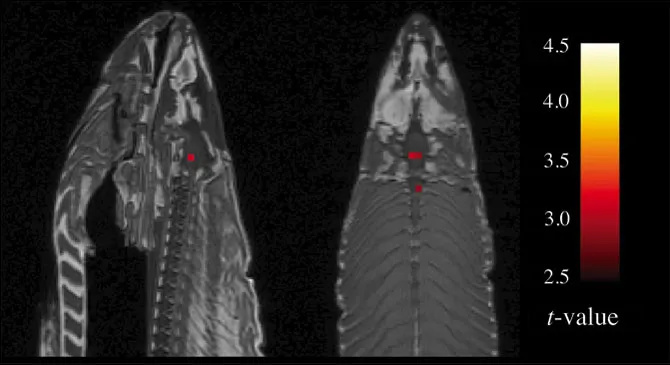

Applying a threshold, particularly one that corrects for multiple comparisons (e.g., using Family-Wise Error (FWE) or False Discovery Rate (FDR) corrections), helps ensure that the displayed activations are statistically reliable. For more information on multiple comparisons correction, see [Rik’s Stats tutorial](../02_Statistics/cognestic_stats_python.ipynb).

### Control the False Positive Rate

A minimum recommendation in the fMRI analysis is to control the **False Positive Rate** (FPR) at a specific threshold, such as p < .001. This is referred to as 'uncorrected' because it does not account for the number of multiple comparisons, but it can still help reduce false positives to a reasonable level when applied conservatively.

In [ ]:
# Obtain the statistical threshold
_, threshold_fpr = threshold_stats_img(
    z_map, 
    alpha = .001, 
    height_control = 'fpr'
)

print('Uncorrected p<.001 threshold: %.3f' % threshold_fpr)

# plot the thresholded map
plot_stat_map(
    z_map, 
    bg_img = preprocessed_anatomical_file, 
    threshold = threshold_fpr,
    cut_coords=MNI_coord[0], # let's center the plot on our previously used example voxel
    display_mode = 'ortho', 
    black_bg = True,
    title = 'Faces > Scrambled  (p<.001, uncorrected)'
)
plt.show()

### False Discovery Rate (FDR) correction

A commonly used alternative to controlling the false positive rate is the **False Discovery Rate** (FDR) method, which addresses the expected proportion of false discoveries among all detected activations. However, in neuroimaging research, the appropriateness of FDR remains a topic of debate. While it is often preferred in exploratory or hypothesis-generating studies due to its balance between discovery and error control, it may be less suitable for confirmatory studies where stricter error control is required.

In [ ]:
_, threshold_fdr = threshold_stats_img(
    z_map, 
    alpha = .05, 
    height_control = 'fdr'
)

print('FDR, p<.05 threshold: %.3f' % threshold_fdr)

plot_stat_map(
    z_map, 
    bg_img = preprocessed_anatomical_file, 
    threshold = threshold_fdr,
    cut_coords=MNI_coord[0], # let's center the plot on our previously used example voxel
    display_mode = 'ortho', 
    black_bg = True,
    title = 'Faces > Scrambled  (p<.05, FDR corrected)'
)
plt.show()

### Family Wise Error (FWE) correction

A more conservative approach is to control the **Family-Wise Error** (FWE) rate, which represents the probability of making one or more false discoveries, or Type I errors, across all tests. This rate is typically set at 5%. The **Bonferroni correction** is a commonly used method to achieve this level of control and is also used in Nilearn. 

In Nilearn, Bonferroni correction is applied to the number of voxels. The Bonferroni correction, when applied directly to the number of voxels, is not appropriate for fMRI data. This is because neuroimaging data typically have spatially correlated data points, which violate the Bonferroni assumption of independent tests. As an alternative, neuroscientists have developed **Random Field Theory** (RFT). This method accounts for the spatial correlation by applying multiple comparison correction in a way that considers the smoothness of the data. Specifically, the correction is applied to the number of '***resels'*** (RESolution ELements), rather than the raw number of voxels. However, it's important to note that this **RFT-based approach is not implemented in Nilearn**. 
At the second-level analysis, Nilearn provides an option for non-parametric inference with permutation testing, which is a more suitable approach for fMRI data when considering the spatial correlation of voxels. 

In [ ]:
_, threshold_fwe = threshold_stats_img(
    z_map, 
    alpha = .05, 
    height_control = 'bonferroni')

print('Bonferroni-corrected, p<.05 threshold: %.3f' % threshold_fwe)

plot_stat_map(
    z_map, 
    bg_img = preprocessed_anatomical_file, 
    threshold = threshold_fwe,
    cut_coords=MNI_coord[0], # let's center the plot on our previously used example voxel
    display_mode = 'ortho', 
    black_bg = True,
    title = 'Faces > Scrambled  (p<.05, FWE corrected)'
)
plt.show()

### Cluster threshold

It's a common practice to discard isolated voxels from the images. It is possible to generate a thresholded map with small clusters removed by providing a `cluster_threshold` argument. Here clusters smaller than `20` voxels will be discarded from the `fpr` corrected map.

In [ ]:
thresholded_map_fpr, threshold_fpr = threshold_stats_img(
    z_map, 
    alpha = .001, 
    height_control='fpr', 
    cluster_threshold = 20
)

plot_stat_map(
    thresholded_map_fpr, 
    bg_img = preprocessed_anatomical_file, 
    threshold = threshold_fpr,
    cut_coords=MNI_coord[0], # let's center the plot on our previously used example voxel
    display_mode = 'ortho', 
    black_bg = True, 
    colorbar = True,
    title = 'Faces > Scrambled (p<.001, uncorrected, k=20'
)
plt.show()

## The impact of first-level model parameters

See the Nilearn tutorial for more examples on how the first_level parameters impact the results: https://nilearn.github.io/stable/auto_examples/04_glm_first_level/plot_first_level_details.html

Here we will just compare our original model where we used Glover's HRF to a model SPM's HRF. 

### Model 1: Glover's HRF

In [ ]:
"""
fmri_glm = FirstLevelModel(
    t_r = TR,
    slice_time_ref = slice_time_ref,
    smoothing_fwhm = 6,
    hrf_model = 'glover',
    drift_model = 'cosine', 
    high_pass = 0.01, 
    noise_model = 'ar1',
    memory = 'FaceProcessing/scratch',
    n_jobs = 2
)

fmri_glm = fmri_glm.fit(bold, events, confounds_glm)

"""

In [46]:
model1_z_map = z_map
model1_title = 'Glover HRF model, Faces > Scrambled'

### Model 2: SPM's HRF

In [ ]:
fmri_glm2 = FirstLevelModel(
    t_r = TR,
    slice_time_ref = slice_time_ref,
    smoothing_fwhm = 6,
    hrf_model = 'spm',
    drift_model = 'cosine', 
    high_pass = 0.01, 
    noise_model = 'ar1',
    memory = 'FaceProcessing/scratch', 
    n_jobs = 2
)

fmri_glm2 = fmri_glm2.fit(preproc_functional_files, event_files, confounds_for_glm)

# fmri_glm2 = fmri_glm2.fit(preproc_functional_files[:2], event_files[:2], confounds_for_glm[:2])

# Remove the cashed directory

!rm -rf FaceProcessing/scratch/joblib/


This model has the same regressors as model1, therefore we can use our original (model1) contrasts.

In [ ]:
model2_z_map = fmri_glm2.compute_contrast(
  [c['Faces_Scrambled'] for c in comparison_contrast_list],
  output_type='z_score')

model2_title = 'SPM HRF model, Faces > Scrambled'

### Plotting both models

In [ ]:
z_maps = [model1_z_map, model2_z_map]
titles = [model1_title, model2_title]

for (z_map, title) in zip(z_maps, titles):
    _, threshold = threshold_stats_img(z_map, alpha = .001, height_control = 'fpr')
    plot_stat_map(
      z_map, 
      bg_img = preprocessed_anatomical_file, 
      threshold = threshold,
      display_mode = 'ortho', 
      cut_coords=MNI_coord[0], # let's center the plot on our previously used example voxel
      black_bg = True,
      title = title
      )
plt.show()

## First Level for multiple subjects

### A generic first-level analysis script

Using a notebook like this is an effective method for preparing the final analysis script. Now, we can combine all the elements discussed into a unified, generic script that will conduct the first-level analysis.

**Example of a generic first-level script**: [code-examples/first_level_script.py](code-examples/first_level_script.py)

**Things to note:**
* We are saving the result files in BIDS format so that they can be easily queried with PyBIDS for further analysis.
* We are generating a *dataset_description.json* file for the result model, which is required to make the results directory BIDS-compatible. This file will also contain our model parameters, which is useful for understanding how the results were obtained.

**Main steps:**
1. Specify the input and output paths and the subject's ID. The input should be the BIDS dataset, which contains the derivatives folder with fmriprep's preprocessed data.
2. Specify the subject's preprocessed functional, event, and confound files.
3. Specify the confounds of interest.
4. Specify the first-level model parameters and fit the model.
5. Specify the contrasts (in this example, the contrasts include Faces > Scrambled, Effects of Interest, and single contrasts for each of the nine conditions).
6. Compute the contrasts and save the results in BIDS format.
7. Create the model's *dataset_description.json* file.

```python
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# ======================================================================
# Dace Apšvalka (MRC CBU 2024)
# Subject-level fMRI analysis using Nilearn
# 
# This script requres step08_first_level_analysis.sh, unless you define ds, sID, 
# and output here manually 
#
# ======================================================================

# ======================================================================
# IMPORT REQUIRED PACKAGES
# ======================================================================
import os
import sys
import pandas as pd
import numpy as np
from bids.layout import BIDSLayout
from nilearn.glm.first_level import FirstLevelModel
import time
import warnings
warnings.filterwarnings("ignore")

# ======================================================================
# DEFINE PATHS
# arguments passed from step08_first_level_analysis.sh
# ======================================================================

ds = sys.argv[1] # dataset location
sID = sys.argv[2].split("sub-")[1] # subject id
output = sys.argv[3]

# ======================================================================
print("Running first-level analysis for subject " + sID)
start_time = time.time()
print("Started at: " + time.strftime("%H:%M:%S", time.localtime()))

# ======================================================================
# DEFINE PARAMETERS
# =====================================================================
model_name = 'first-level'

bids_path = os.path.join(ds, 'data')

outdir = os.path.join(output, model_name, 'sub-' + sID)
if not os.path.exists(outdir):
    os.makedirs(outdir)

print("BIDS data location: " + bids_path)
print("Output directory: " + outdir)

# ======================================================================
# PERFORM SUBJECT LEVEL GLM ANALYSIS
# ======================================================================

# --- Initialize the BIDS layout and include the derivatives in it
layout = BIDSLayout(bids_path, derivatives=True)

# --- Get the preprocessed functional files
bold = layout.get(
    subject=sID, 
    datatype='func', 
    space='MNI152NLin2009cAsym', 
    desc='preproc', 
    extension='.nii.gz',
    return_type='filename'
    )
print("Found " + str(len(bold)) + " preprocessed functional files")

# --- Get the event files
events = layout.get(
    subject=sID, 
    datatype='func', 
    suffix='events', 
    extension=".tsv", 
    return_type='filename'
    )
print("Found " + str(len(events)) + " event files")

# --- Get the confounds and select which ones to include in the design
confounds = layout.get(
    subject=sID, 
    datatype='func', 
    desc='confounds', 
    extension=".tsv", 
    return_type='filename'
    )
print("Found " + str(len(confounds)) + " confounds files")

# --- Define which confounds to include in the GLM
confounds_of_interest = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 
                         'non_steady_state_outlier00', 'non_steady_state_outlier01']

# --- For each run, load the confounds and select the ones of interest
confounds_glm = []
for conf_file in confounds:
    this_conf = pd.read_table(conf_file)
    # only include the confounds of interest that are present in the file
    confounds_of_interest = [conf for conf in confounds_of_interest if conf in this_conf.columns]
    # select the confounds of interest and fill NaN with 0    
    conf_subset = this_conf[confounds_of_interest].fillna(0) # replace NaN with 0
    confounds_glm.append(conf_subset)

# --- Get the TR value
TR = layout.get_tr()

# --- If slice timing correction was applied, get the slice time reference
slice_timing = layout.get_metadata(bold[0])
if slice_timing['SliceTimingCorrected']:
  slice_time_ref = slice_timing['StartTime'] / TR
else:
  slice_time_ref = 0

# --- Define the GLM model
fmri_glm = FirstLevelModel(
    t_r = TR,
    slice_time_ref = slice_time_ref, 
    hrf_model = 'glover',
    drift_model = 'cosine',
    high_pass = 0.01,
    noise_model = 'ar1',
    smoothing_fwhm = 6
    )

# --- Fit the model
fmri_glm = fmri_glm.fit(bold, events, confounds_glm)

# --- Get the design matrices
design_matrices = fmri_glm.design_matrices_

# --- Create contrasts 
events_df = pd.read_table(events[0])
unique_conditions = events_df['trial_type'].unique()

contrast_list = []
nruns = len(design_matrices)

for design_matrix in design_matrices:
    n_columns = design_matrix.shape[1]  # number of predictors in the model
    column_names = design_matrix.columns  # get the names of the columns
    
    # Create an empty dictionary to store contrasts for all conditions
    contrasts = {}
    
    # ------------------------------------------------------------------
    # Create a contrast vector for each condition
    # ------------------------------------------------------------------
    for condition in unique_conditions:
        # Initialize the contrast vector with zeros
        contrast_vector = np.zeros(n_columns)
        
        # Assign 1 to the columns that correspond to the current condition and scale by the number of runs
        for i, col_name in enumerate(column_names):
            if col_name.startswith(condition):
                contrast_vector[i] = 1/nruns
        
        # Store the contrast for the current condition
        contrasts[condition] = contrast_vector
        
    # ------------------------------------------------------------------
    # Create contrast for Faces > Scrambled
    # ------------------------------------------------------------------
    # Calculate the number of "Faces" and "Scrambled" conditions
    num_faces = sum(1 for col_name in column_names if col_name.startswith(('FAMOUS', 'UNFAMILIAR')))
    num_scrambled = sum(1 for col_name in column_names if col_name.startswith('SCRAMBLED'))
    
    # Initialize the contrast vector with zeros
    contrast_vector = np.zeros(n_columns)
    
    # Assign weights to the contrast vector
    for i, col_name in enumerate(column_names):
        if col_name.startswith(('FAMOUS', 'UNFAMILIAR')):
            contrast_vector[i] = 1 / num_faces /nruns # weigh the faces conditions
        elif col_name.startswith('SCRAMBLED'):
            contrast_vector[i] = -1 / num_scrambled/nruns  # weigh the scrambled conditions
    
    contrasts['Faces_Scrambled'] = contrast_vector
    
    # ------------------------------------------------------------------
    # Create effects of interest contrast
    # ------------------------------------------------------------------
    contrasts['EffectsOfInterest'] = np.eye(n_columns)[:len(unique_conditions)]
    
    # Append all contrasts for this design matrix
    contrast_list.append(contrasts)
    
# --- Compute the contrasts and save the results
for contrast_id in contrast_list[0].keys():   
    if contrast_id == 'EffectsOfInterest':
        stats = 'z_score' 
    else:
        stats = 'effect_size'
    stats_map = fmri_glm.compute_contrast(
        [c[contrast_id] for c in contrast_list], 
        output_type = stats)
    # Save results following BIDS standart
    res_name = os.path.basename(bold[0]).split("run")[0]
    # from stats get only the part before _ for the BIDS file name
    stats_suffix = stats.split("_")[0]
    # in contrast_id remove underscores
    contrast_id = contrast_id.replace("_", "")
    # Save the result
    stats_map.to_filename(os.path.join(outdir, res_name + 'desc-' + contrast_id + '_' + stats_suffix + '.nii.gz'))

# ======================================================================
# CREATE THIS MODEL'S dataset_description.json FILE
# This is needed to use the results directory as BIDS data. 
# We will save our model parameters in the file as well, which is very useful.
# ======================================================================

jason_file = os.path.join(output, model_name, "dataset_description.json")

if not os.path.exists(jason_file):
    import json
    import datetime
    from importlib.metadata import version

    bids_version = layout.get_dataset_description()['BIDSVersion']
    nilearn_version = version('nilearn')
    date_created = datetime.datetime.now()
    
    # Data to be written
    content = {
        "Name": "First-level GLM analysis",
        "BIDSVersion": bids_version,
        "DatasetType": "results",
        "GeneratedBy": [
            {
                "Name": "Nilearn",
                "Version": nilearn_version,
                "CodeURL": "https://nilearn.github.io"
            }
        ],    
        "Date": date_created,
        "ConfoundsIncluded": confounds_of_interest,
        "FirstLevelModel": [
            fmri_glm.get_params()
        ], 
    }
    
    # Serializing json
    json_object = json.dumps(content, indent=4, default=str)
    
    # Writing to .json
    with open(jason_file, "w") as outfile:
        outfile.write(json_object)

# ======================================================================
print("Finished first-level analysis for subject " + sID)
print("Finished at: " + time.strftime("%H:%M:%S", time.localtime()))
print("Processing time: " + str(round((time.time() - start_time)/60, 2)) + " minutes")

```

### Processing multiple subjects in paralel

#### **Using `SLURM`**
  
If `SLURM `is available on the system, you can create a project-specific script where you define the paths and use the `sbatch` command to execute the generic script for each subject in parallel using.

**Example script**: [step08_first_level_analysis.sh](code-examples/step08_first_level_analysis.sh)

If `SLURM` is not available, you can still process multiple subjects in parallel using alternative methods depending on the system you're working with.
  
#### **Using Python's `multiprocessing` Module**
  
Python's `multiprocessing` module allows you to run processes in parallel on your local machine, distributing the workload across multiple CPU cores. An advantage is that it can be run on a single machine without needing a cluster or SLURM. A disatvantage is that it is limited by the local resources (RAM, CPU), and not ideal for very large datasets or many subjects.
Here is an example how you could use the `multiprocessing` module:

```python
import multiprocessing as mp
import os

# Define a function to process a single subject
def process_subject(subject_id, dataset_location, output_dir):
    # Execute the first-level script with the appropriate arguments
    os.system(f"python first_level_script.py {dataset_location} sub-{subject_id} {output_dir}")

# Define the dataset location and output directory
dataset_location = "/path/to/bids_dataset"
output_dir = "/path/to/output"

# List of subject IDs
subjects = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16']
# subjects = [f"{i:02d}" for i in range(1, 17)]

# Create a pool of processes using the available CPU cores
if __name__ == '__main__':
    pool = mp.Pool(mp.cpu_count())  # Use all available CPU cores

    # Use pool.starmap to pass multiple arguments to the process_subject function
    pool.starmap(process_subject, [(subject, dataset_location, output_dir) for subject in subjects])

    # Close the pool and wait for the processes to complete
    pool.close()
    pool.join()

  ```

#### **Using Cloud Services**
  
If you don’t have SLURM or a powerful local machine, cloud computing platforms (e.g., AWS, Google Cloud, Microsoft Azure) allow you to run parallel processes with scalable resources. You can set up virtual machines or use a service like AWS Batch or Google Cloud Dataflow to handle parallel jobs across multiple subjects. However, it requires cloud expertise and comes with costs.